# Importing data and modules

Importing

In [59]:
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
from scipy.optimize import fmin
import matplotlib.ticker as mtick
import os
from pathlib import Path
from typing import List, Optional, Union
from scipy.optimize import nnls
import statsmodels.api as sm
import matplotlib.pyplot as plt

import cvxpy as cp 

import yfinance as yf

import itertools
import networkx as nx

from scipy import stats
from collections import deque
import time
import logging

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

## Description of the data

Below a code that loads and merges simulation csv files into a single pandas database. The report used in RiskMetrics is Var 1 D - Histo 1Y - Simulated Levels applied to a bunch of Risk factors imported under portfolios named "Proxy Review - XXX" on user amundi11. 

## Defining load and merge function

In [29]:
def load_and_merge_csvs(
    paths: Optional[Union[str, Path, List[Union[str, Path]]]] = None,
    directory: Optional[Union[str, Path]] = None,
    date_col: str = "Scenario[Scenario]",
    date_format: str = "%Y%m%d",
) -> pd.DataFrame:
    """
    Load multiple CSVs and merge them into one DataFrame named `returns`.

    - Provide either `paths` (single path or list of paths) or `directory` (path containing CSVs).
    - Parses `date_col` using date_format (default YYYYMMDD -> %Y%m%d).
    - Aligns/outer-joins on the parsed date column (sets it as index).
    - Preserves original column names (no suffixes), allowing duplicate column names.

    Returns:
        pandas.DataFrame named `returns`.
    """
    if paths is None and directory is None:
        raise ValueError("Provide either paths or directory")

    # Build list of file paths
    file_paths: List[Path] = []
    if directory is not None:
        p = Path(directory)
        if not p.is_dir():
            raise ValueError(f"directory {directory} is not a valid directory")
        file_paths = sorted([f for f in p.glob("*.csv") if f.is_file()])
    else:
        if isinstance(paths, (str, Path)):
            file_paths = [Path(paths)]
        else:
            file_paths = [Path(x) for x in paths]
        # validate
    file_paths = [fp for fp in file_paths if fp.exists()]
    if not file_paths:
        raise ValueError("No CSV files found to load")

    dfs = []
    for fp in file_paths:
        # Read CSV
        df = pd.read_csv(fp, dtype=str)  # read as str first to avoid parsing surprises
        if 'level' in df.columns:
            df = df.drop(columns=['level'])
        if 'Simulated Returns 1 [1][Simulated Returns 1\Total]' in df.columns:
            df = df.drop(columns=['Simulated Returns 1 [1][Simulated Returns 1\Total]'])
        if 'Simulated Levels [1][Simulated Levels\Total]' in df.columns:
            df = df.drop(columns=['Simulated Levels [1][Simulated Levels\Total]'])
        
        if date_col not in df.columns:
            raise KeyError(f"Date column '{date_col}' not found in {fp.name}")
        # Parse date column to datetime
        df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors="coerce")
        if df[date_col].isna().any():
            # optional: warn about unparsable rows
            nbad = df[date_col].isna().sum()
            print(f"Warning: {nbad} rows in {fp.name} had unparsable {date_col} and became NaT")
        # Set index to the parsed date column
        df = df.set_index(date_col)
        # Keep all other columns as-is (do not rename)
        # Convert non-date columns to numeric where sensible, otherwise leave as string
        # Attempt to infer dtypes for remaining columns
        non_index_cols = df.columns
        df[non_index_cols] = df[non_index_cols].apply(pd.to_numeric, errors="ignore")
        dfs.append(df)

    # Align on the index using an outer join while preserving duplicate column names.
    # Approach: reindex to the union of all indices, then concatenate along columns.
    # Compute full index (sorted unique datetimes)
    full_index = pd.Index(sorted(set().union(*[set(d.index) for d in dfs])))
    reindexed = [d.reindex(full_index) for d in dfs]

    # Concatenate horizontally; this will preserve original column names and allow duplicates.
    returns = pd.concat(reindexed, axis=1)

    # Optionally, set the name of the index
    returns.index.name = date_col

    return returns


<>:44: SyntaxWarning: invalid escape sequence '\T'
<>:45: SyntaxWarning: invalid escape sequence '\T'
<>:46: SyntaxWarning: invalid escape sequence '\T'
<>:47: SyntaxWarning: invalid escape sequence '\T'
<>:44: SyntaxWarning: invalid escape sequence '\T'
<>:45: SyntaxWarning: invalid escape sequence '\T'
<>:46: SyntaxWarning: invalid escape sequence '\T'
<>:47: SyntaxWarning: invalid escape sequence '\T'
C:\Users\charlety\AppData\Local\Temp\ipykernel_5800\4202231438.py:44: SyntaxWarning: invalid escape sequence '\T'
  if 'Simulated Returns 1 [1][Simulated Returns 1\Total]' in df.columns:
C:\Users\charlety\AppData\Local\Temp\ipykernel_5800\4202231438.py:45: SyntaxWarning: invalid escape sequence '\T'
  df = df.drop(columns=['Simulated Returns 1 [1][Simulated Returns 1\Total]'])
C:\Users\charlety\AppData\Local\Temp\ipykernel_5800\4202231438.py:46: SyntaxWarning: invalid escape sequence '\T'
  if 'Simulated Levels [1][Simulated Levels\Total]' in df.columns:
C:\Users\charlety\AppData\Local

## Define path to stored data

Important : we assume that the target index levels simulation is stored under a folder named 'target' and the features under a folder named 'features'

In [30]:

# path = r"P:\RISQUES\RCS\RISQUES DE MARCHE\MRM\Z_Vincent\Code\Proxy\BBgBarc Global Aggregate\Validation VaR 1Y - Pnls detailles position"
path = r"P:\RISQUES\RCS\RISQUES DE MARCHE\MRM\Z_Vincent\Code\Proxy\BBgBarc Global Aggregate\Simulated Top Levels - 1Y.csv"
dffeatures = load_and_merge_csvs(directory=path + "\\features")
dftarget = load_and_merge_csvs(directory=path + "\\target")
data = pd.concat([dffeatures,dftarget],axis=1)
data

C:\Users\charlety\AppData\Local\Temp\ipykernel_5800\4202231438.py:63: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[non_index_cols] = df[non_index_cols].apply(pd.to_numeric, errors="ignore")
C:\Users\charlety\AppData\Local\Temp\ipykernel_5800\4202231438.py:63: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[non_index_cols] = df[non_index_cols].apply(pd.to_numeric, errors="ignore")
C:\Users\charlety\AppData\Local\Temp\ipykernel_5800\4202231438.py:63: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[non_index_cols] = df[non_index_cols].apply(pd.to_numeric, errors="ignore")
C:\Users\charlety\AppData\Local\Temp\ipykernel_5800\4202231438.py:6

,Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y],Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y],Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y],Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y],Simulated Levels [1]_3663846047_3663846049[Simulated Levels\CDX.NA.IG.OTR.5Y],Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y],Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y],Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y],Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y],Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y],...,Simulated Levels [1]_3665894383_3665894385[Simulated Levels\GBP Govt 5Y],Simulated Levels [1]_3663846043_3663846045[Simulated Levels\iTraxx Europe OTR 5Y],Simulated Levels [1]_3665894419_3665894421[Simulated Levels\JPY Govt 10Y],Simulated Levels [1]_3665894407_3665894409[Simulated Levels\JPY Govt 20Y],Simulated Levels [1]_3663846039_3663846041[Simulated Levels\JPY Govt 5Y],Simulated Levels [1]_3665894423_3665894425[Simulated Levels\USD Govt 10Y],Simulated Levels [1]_3665894403_3665894405[Simulated Levels\USD Govt 20Y],Simulated Levels [1]_3663846035_3663846037[Simulated Levels\USD Govt 5Y],Simulated Levels [1]_3663846027_3663846029[Simulated Levels\USD Swap 5Y],Simulated Level [1][Simulated Level]
Scenario[Scenario],,,,,,,,,,,,,,,,,,,,,
2024-10-18,1.000326,1.000255,1.000352,100.000447,100.002346,1.000101,1.000065,1.000075,1.000255,1.000285,...,1.000389,100.002425,1.000022,0.999837,1.000021,1.000052,0.999998,1.000204,1.000258,9.993375e+05
2024-10-21,0.998896,0.998930,0.998894,99.967346,99.991761,0.999879,0.999931,0.999898,0.998920,0.998926,...,0.999409,99.986053,0.999945,0.999987,1.000071,0.998860,0.998903,0.998912,0.998997,9.959314e+05
2024-10-22,0.999978,1.000071,1.000153,99.980781,99.996113,0.999862,0.999849,0.999872,0.999740,0.999792,...,0.999774,99.993658,0.999932,0.999785,0.999890,0.999890,1.000006,0.999798,0.999738,9.997916e+05
2024-10-23,0.999697,0.999772,0.999711,99.981801,99.989620,0.999817,0.999840,0.999837,0.999980,0.999984,...,0.999459,99.992425,0.999968,0.999983,1.000031,0.999613,0.999702,0.999496,0.999492,9.994173e+05
2024-10-24,1.000268,1.000468,1.000125,100.019639,100.007895,0.999947,0.999901,0.999992,1.000465,1.000402,...,0.999589,100.006549,1.000247,1.000158,1.000101,1.000379,1.000433,1.000236,1.000409,1.001178e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-13,1.000000,1.000000,1.000000,100.000000,100.000000,1.000078,1.000014,1.000046,1.000051,1.000020,...,1.000344,100.005918,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.001426e+06
2025-10-14,1.000140,1.000367,1.000158,100.032922,100.021643,1.000030,1.000019,1.000029,1.000360,1.000371,...,1.000477,100.008074,1.000469,0.999833,1.000403,1.000050,0.999832,1.000294,1.000266,9.989861e+05
2025-10-15,1.000325,1.000263,1.000265,100.025096,100.005045,1.000045,1.000052,1.000010,1.000240,1.000298,...,1.000392,100.018201,0.999926,1.000335,0.999767,1.000052,1.000019,0.999931,0.999802,9.999771e+05


# Feature engineering (TBD : FX conversion from USD to EUR)

The FX factors in RiskMetrics are USD based. For our purpose, we would need to have them EUR based. We will convert them using the EUR FX factor which is the spot USD/EUR. Thus we will multiply our FX data by 1/FX EUR factor.
Additionnally we will work with log returns to remove autocorrelation from the data.

In [31]:
FXfeatures = [i for i in data.columns if i.find('FX') != -1]
FXfeaturesInUSD = [i for i in data.columns if i.find('FX') != -1 and i.find('EUR') == -1]
FXUSDEUR = [i for i in data.columns if i.find('FX') != -1 and i.find('EUR') != -1]
# data[FXfeaturesInUSD] = data[FXfeaturesInUSD].div(data[FXUSDEUR], axis=0)
# data[FXfeaturesInUSD]

In [56]:
data[FXfeatures]

,Simulated Levels [1]_3667644721_3667644723[Simulated Levels\FX CAD],Simulated Levels [1]_3667644733_3667644735[Simulated Levels\FX CNY],Simulated Levels [1]_3678075716_3678075718[Simulated Levels\FX EUR],Simulated Levels [1]_3667644725_3667644727[Simulated Levels\FX GBP],Simulated Levels [1]_3667644729_3667644731[Simulated Levels\FX JPY]
Scenario[Scenario],,,,,
2024-10-18,1.004042,1.002794,0.996821,0.999158,1.003170
2024-10-21,0.999051,0.997753,1.002418,1.001226,0.997616
2024-10-22,0.996596,0.997500,1.002692,0.999729,0.997348
2024-10-23,0.997619,0.996352,1.003778,0.999321,0.996326
2024-10-24,1.002545,1.002170,0.997564,1.001302,1.002393
...,...,...,...,...,...
2025-10-13,0.999836,0.998289,1.001914,0.995779,0.998087
2025-10-14,1.003977,1.003546,0.996619,1.006467,1.003369
2025-10-15,1.002825,1.002642,0.997031,0.996159,1.002958


## Converting to EUR FX riskfactors

This is a non negligeable step, as it shifts the below regression results completely

In [ ]:
# data[FXfeaturesInUSD] = data[FXfeaturesInUSD].div(data[FXUSDEUR].values, axis = 0)

In [57]:
FXfeaturesInUSD

['Simulated Levels [1]_3667644721_3667644723[Simulated Levels\\FX CAD]',
 'Simulated Levels [1]_3667644733_3667644735[Simulated Levels\\FX CNY]',
 'Simulated Levels [1]_3667644725_3667644727[Simulated Levels\\FX GBP]',
 'Simulated Levels [1]_3667644729_3667644731[Simulated Levels\\FX JPY]']

Converting to log returns

In [34]:
returns = np.log(data / data.shift(1))

In [35]:
# returns = pd.read_csv(r'P:\RISQUES\RCS\RISQUES DE MARCHE\MRM\Z_Vincent\Code\Proxy\Daily Returns (%).CSV')
# returns.drop(columns=['level'],inplace=True)
# returns.rename(columns={'number[Date]' : 'Date'}, inplace= True)
# returns.set_index('Date',inplace=True)
# returns.index = pd.to_datetime(returns.index)
# returns

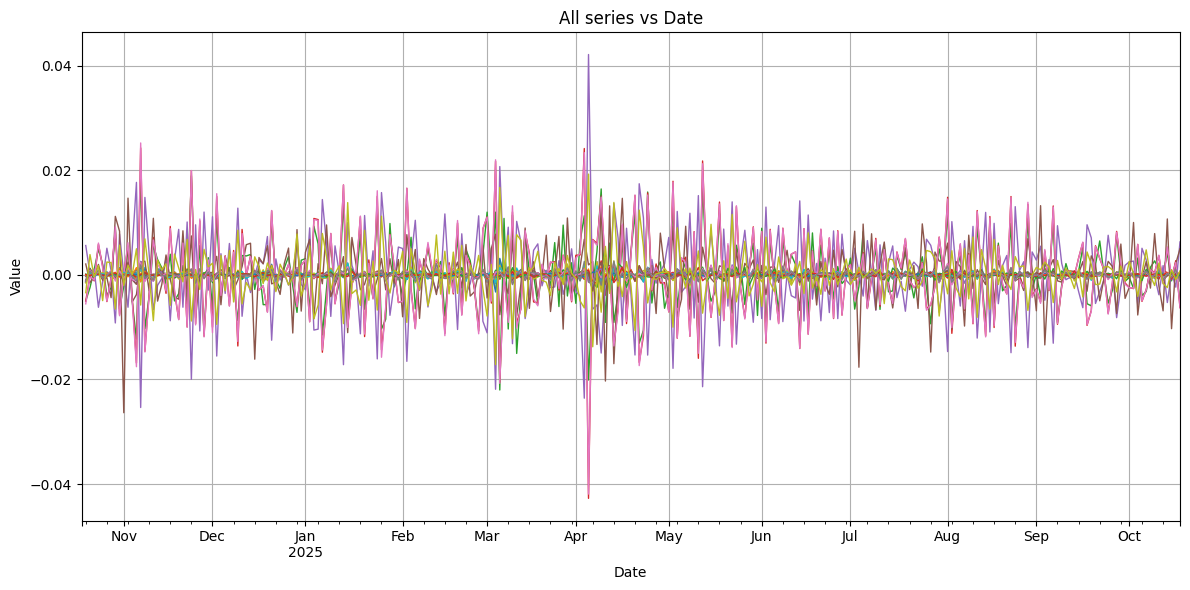

In [36]:
ax = returns.plot(figsize=(12, 6), linewidth=1, legend = False)
ax.set_title("All series vs Date")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.grid(True)
plt.tight_layout()
plt.show()

# Regressing the data

## Defining target and features

In [37]:
returns.columns

Index(['Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y]',
       'Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y]',
       'Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y]',
       'Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y]',
       'Simulated Levels [1]_3663846047_3663846049[Simulated Levels\CDX.NA.IG.OTR.5Y]',
       'Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y]',
       'Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y]',
       'Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y]',
       'Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y]',
       'Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y]',
       'Simulated Levels [1]_3663846031_3663846033[Simulated Levels\EUR Govt 5Y]',
       'Simulated Levels [1]_3663846013_3663846021[Simulated Levels\EUR Sw

In [38]:


# features = [r'CDS.CDX-EMOTR-5Y 60M(2)[CDX.EM.OTR\60M]',
#        r'CDS.CDX-NAIGOTR-5Y 60M(3)[CDX.NA.IG.OTR\60M]',
#        r'CDS.ITRAXX-EUROPEOTR-5Y 60M(4)[iTraxx Europe OTR\60M]',
#        r'EUR Govt 60M(5)[Euro Government Debt Benchmark - Zero Coupon\60M]',
#        r'EUR Swap 60M(6)[Euro Zero Coupon Swap Rate\60M]',
#        r'JPY Govt 60M(7)[Japanese Government Debt Benchmark - Zero Coupon\60M]',
#        r'USD Govt 60M(9)[US Government Debt Benchmark - Zero Coupon\60M]',
#        r'USD Swap 60M(10)[US Interest Rate Swap - Zero Coupon\60M]']

# features = [r'CDS.CDX-EMOTR-5Y 60M(2)[CDX.EM.OTR\60M]',
#        r'CDS.CDX-NAIGOTR-5Y 60M(3)[CDX.NA.IG.OTR\60M]',
#        r'CDS.ITRAXX-EUROPEOTR-5Y 60M(4)[iTraxx Europe OTR\60M]',
#        r'EUR Govt 60M(5)[Euro Government Debt Benchmark - Zero Coupon\60M]',
#        r'JPY Govt 60M(7)[Japanese Government Debt Benchmark - Zero Coupon\60M]',
#        r'USD Govt 60M(9)[US Government Debt Benchmark - Zero Coupon\60M]']

# features = [r'CDS.CDX-NAIGOTR-5Y 60M(3)[CDX.NA.IG.OTR\60M]',
#        r'CDS.ITRAXX-EUROPEOTR-5Y 60M(4)[iTraxx Europe OTR\60M]',
#        r'EUR Govt 60M(5)[Euro Government Debt Benchmark - Zero Coupon\60M]',
#        r'JPY Govt 60M(7)[Japanese Government Debt Benchmark - Zero Coupon\60M]',
#        r'USD Govt 60M(9)[US Government Debt Benchmark - Zero Coupon\60M]']

# target = ['RMXIX3100187184(8)[Bloomberg Barclays Global Aggregate Hedged in EUR]']

target = returns.columns[-1]
features = returns.columns[:len(returns.columns)-1]


returns[features]

,Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y],Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y],Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y],Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y],Simulated Levels [1]_3663846047_3663846049[Simulated Levels\CDX.NA.IG.OTR.5Y],Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y],Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y],Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y],Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y],Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y],...,Simulated Levels [1]_3665894379_3665894381[Simulated Levels\GBP Govt 20Y],Simulated Levels [1]_3665894383_3665894385[Simulated Levels\GBP Govt 5Y],Simulated Levels [1]_3663846043_3663846045[Simulated Levels\iTraxx Europe OTR 5Y],Simulated Levels [1]_3665894419_3665894421[Simulated Levels\JPY Govt 10Y],Simulated Levels [1]_3665894407_3665894409[Simulated Levels\JPY Govt 20Y],Simulated Levels [1]_3663846039_3663846041[Simulated Levels\JPY Govt 5Y],Simulated Levels [1]_3665894423_3665894425[Simulated Levels\USD Govt 10Y],Simulated Levels [1]_3665894403_3665894405[Simulated Levels\USD Govt 20Y],Simulated Levels [1]_3663846035_3663846037[Simulated Levels\USD Govt 5Y],Simulated Levels [1]_3663846027_3663846029[Simulated Levels\USD Swap 5Y]
Scenario[Scenario],,,,,,,,,,,,,,,,,,,,,
2024-10-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-21,-0.001430,-0.001326,-0.001459,-0.000331,-0.000106,-0.000223,-0.000134,-0.000177,-0.001336,-0.001359,...,-0.001534,-0.000980,-0.000164,-0.000076,0.000150,0.000050,-0.001192,-0.001096,-0.001292,-0.001261
2024-10-22,0.001083,0.001142,0.001260,0.000134,0.000044,-0.000017,-0.000082,-0.000026,0.000821,0.000867,...,0.000815,0.000365,0.000076,-0.000013,-0.000202,-0.000181,0.001031,0.001103,0.000886,0.000741
2024-10-23,-0.000281,-0.000299,-0.000442,0.000010,-0.000065,-0.000045,-0.000009,-0.000035,0.000240,0.000191,...,-0.000042,-0.000315,-0.000012,0.000036,0.000198,0.000141,-0.000277,-0.000304,-0.000302,-0.000246
2024-10-24,0.000571,0.000696,0.000414,0.000378,0.000183,0.000130,0.000061,0.000156,0.000485,0.000419,...,0.000078,0.000130,0.000141,0.000279,0.000175,0.000071,0.000767,0.000731,0.000740,0.000917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-13,-0.000465,-0.000490,-0.000248,0.001000,0.000319,-0.000156,-0.000169,-0.000126,-0.000554,-0.000578,...,-0.000112,-0.000121,0.000278,0.000042,-0.000109,-0.000059,-0.000965,-0.001029,-0.000943,-0.000942
2025-10-14,0.000140,0.000366,0.000158,0.000329,0.000216,-0.000048,0.000004,-0.000016,0.000310,0.000351,...,0.000118,0.000133,0.000022,0.000469,-0.000167,0.000403,0.000050,-0.000168,0.000294,0.000266
2025-10-15,0.000185,-0.000104,0.000107,-0.000078,-0.000166,0.000016,0.000034,-0.000019,-0.000121,-0.000073,...,0.000308,-0.000086,0.000101,-0.000542,0.000501,-0.000636,0.000002,0.000187,-0.000363,-0.000464


## TBD exclude one of the pair when corr >0.80

We have a look at the features, a too high correlation between features can cause the regression to fail. For each pair of feature a too high level of correlation, we will drop one of them. This level is set for now at ${0.8}$

In [39]:
print(returns[features].shape)
returns[features].corr()

(261, 28)


,Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y],Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y],Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y],Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y],Simulated Levels [1]_3663846047_3663846049[Simulated Levels\CDX.NA.IG.OTR.5Y],Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y],Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y],Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y],Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y],Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y],...,Simulated Levels [1]_3665894379_3665894381[Simulated Levels\GBP Govt 20Y],Simulated Levels [1]_3665894383_3665894385[Simulated Levels\GBP Govt 5Y],Simulated Levels [1]_3663846043_3663846045[Simulated Levels\iTraxx Europe OTR 5Y],Simulated Levels [1]_3665894419_3665894421[Simulated Levels\JPY Govt 10Y],Simulated Levels [1]_3665894407_3665894409[Simulated Levels\JPY Govt 20Y],Simulated Levels [1]_3663846039_3663846041[Simulated Levels\JPY Govt 5Y],Simulated Levels [1]_3665894423_3665894425[Simulated Levels\USD Govt 10Y],Simulated Levels [1]_3665894403_3665894405[Simulated Levels\USD Govt 20Y],Simulated Levels [1]_3663846035_3663846037[Simulated Levels\USD Govt 5Y],Simulated Levels [1]_3663846027_3663846029[Simulated Levels\USD Swap 5Y]
Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y],1.000000,0.932668,0.932397,0.001896,0.020533,-0.101556,-0.086498,-0.114326,0.439923,0.479735,...,0.390998,0.461671,0.029657,0.106750,0.037731,0.104349,0.780864,0.772270,0.735335,0.635635
Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y],0.932668,1.000000,0.854942,0.117802,0.148074,-0.091050,-0.066644,-0.111618,0.409619,0.475597,...,0.296492,0.348555,-0.022330,0.184016,0.059196,0.175019,0.749437,0.800633,0.643970,0.505148
Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y],0.932397,0.854942,1.000000,-0.096931,-0.094009,-0.103170,-0.107345,-0.122923,0.394898,0.400821,...,0.404540,0.489186,0.093344,-0.007008,0.007000,-0.003154,0.720814,0.665054,0.755892,0.686769
Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y],0.001896,0.117802,-0.096931,1.000000,0.894160,0.003157,0.034618,0.018936,-0.068982,-0.023676,...,-0.374425,-0.274008,0.009485,-0.016724,-0.295400,-0.042669,0.060041,0.147327,-0.108832,-0.288346
Simulated Levels [1]_3663846047_3663846049[Simulated Levels\CDX.NA.IG.OTR.5Y],0.020533,0.148074,-0.094009,0.894160,1.000000,0.037827,0.076533,0.056200,-0.020416,0.004389,...,-0.309246,-0.226610,0.057295,0.060811,-0.215533,0.025788,0.042222,0.112319,-0.129858,-0.281137
Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y],-0.101556,-0.091050,-0.103170,0.003157,0.037827,1.000000,0.928246,0.930947,-0.071143,-0.088546,...,-0.194182,-0.169660,0.005531,0.076669,0.051729,-0.004292,-0.005311,-0.022895,0.008790,-0.000158
Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y],-0.086498,-0.066644,-0.107345,0.034618,0.076533,0.928246,1.000000,0.802751,-0.052448,-0.081428,...,-0.221144,-0.164279,-0.041650,0.145563,0.050297,0.070124,0.012558,0.007373,0.010716,-0.019064
Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y],-0.114326,-0.111618,-0.122923,0.018936,0.056200,0.930947,0.802751,1.000000,-0.049256,-0.064572,...,-0.170211,-0.129776,0.006062,0.079130,0.076094,-0.011219,0.007445,-0.017235,0.018554,0.015805
Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y],0.439923,0.409619,0.394898,-0.068982,-0.020416,-0.071143,-0.052448,-0.049256,1.000000,0.933207,...,0.577163,0.642610,-0.045057,0.105778,0.007601,0.090103,0.395503,0.400230,0.390736,0.461342
Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y],0.479735,0.475597,0.400821,-0.023676,0.0043

## Defining a few diagnostic functions

In [40]:
# def solve_nnls(A, b_vec):
#     """Solve min ||A x - b||^2 subject to x >= 0. Returns x (1D numpy array).
#     """
#     x, rnorm = nnls(A, b_vec)
#     return x

# # constrained fit: require all coefficients b = -c <= -tol_neg
# def constrained_nnls_fit(X_sub_df, y_ser, tol_neg=1e-3):
#     """
#     Fit constrained least squares enforcing b < 0 by solving NNLS for c >= 0 on A = X, b = -y.
#     Returns (adj_r2, model_dict) or (None, None) if infeasible or numerical issues.

#     model_dict contains:
#       - 'coeffs': pd.Series of coefficients (b = -c) indexed by column names
#       - 'coef_se': pd.Series of approximate standard errors (from sigma^2 * pinv(X'X))
#       - 'adj_r2', 'RSS', 'TSS', 'n', 'p', 'dropped_constants', 'solver' etc.
#     """
#     # Drop constant columns
#     X_clean, dropped = drop_constant_columns(X_sub_df)

#     A = X_clean.values.astype(float)
#     y = y_ser.values.astype(float)
#     n, p = A.shape

In [41]:
# --- Helper metrics ---

#     r2 = 1 - RSS/TSS
#     adj_r2 = 1.0 - ( (RSS / (n - p)) / (TSS / n) )


def tracking_error(y, y_hat): 
    return np.std(y - y_hat)

def rmse(y, y_hat): 
    return np.sqrt(np.mean((y - y_hat)**2))

def mae(y, y_hat): 
    return np.mean(np.abs(y - y_hat))

def hit_rate(y, y_hat): 
    return np.mean(np.sign(y) == np.sign(y_hat))

 

# target = 'RMXIX3100187184(8)[Bloomberg Barclays Global Aggregate Hedged in EUR]'

df = returns.copy() 

# Drop rows with missing values (you can choose other treatments)
df = df.dropna()

# defining explanatory and target variable
X = df[features].values 
y = df[target].values

## Differrent regression methods

Let's try first a simple OLS to see what we get

In [42]:

# --- OLS baseline ---
ols_res = sm.OLS(y, X).fit() 
print('OLS summary:') 
print(ols_res.summary())

y_hat_ols = ols_res.predict(X)


OLS summary:
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              1410.
Date:                Tue, 25 Nov 2025   Prob (F-statistic):                   1.75e-242
Time:                        12:24:21   Log-Likelihood:                          1682.4
No. Observations:                 260   AIC:                                     -3309.
Df Residuals:                     232   BIC:                                     -3209.
Df Model:                          28                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

There is an obvious overfitting here (R² of >99%), additionnally variables were not filtered so the linear regression. Let's reduce the number of variables, and add the constraint that every betas should be negative so that it is coherent with the financial interpretation.

### Convex problem solver cvxpy 

In [43]:
returns[FXfeatures]

,Simulated Levels [1]_3667644721_3667644723[Simulated Levels\FX CAD],Simulated Levels [1]_3667644733_3667644735[Simulated Levels\FX CNY],Simulated Levels [1]_3678075716_3678075718[Simulated Levels\FX EUR],Simulated Levels [1]_3667644725_3667644727[Simulated Levels\FX GBP],Simulated Levels [1]_3667644729_3667644731[Simulated Levels\FX JPY]
Scenario[Scenario],,,,,
2024-10-18,NaN,NaN,NaN,NaN,NaN
2024-10-21,-0.004984,-0.005039,0.005599,0.002068,-0.005552
2024-10-22,-0.002460,-0.000254,0.000274,-0.001496,-0.000269
2024-10-23,0.001026,-0.001151,0.001082,-0.000409,-0.001025
2024-10-24,0.004926,0.005822,-0.006210,0.001980,0.006071
...,...,...,...,...,...
2025-10-13,0.000216,-0.001520,0.001761,-0.006888,-0.001737
2025-10-14,0.004133,0.005253,-0.005299,0.010677,0.005278
2025-10-15,-0.001148,-0.000902,0.000414,-0.010295,-0.000409


In [44]:
df = returns.copy()
df1 = df.drop(FXfeatures, axis = 1).values
df1

array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-1.42999092e-03, -1.32619457e-03, -1.45854327e-03, ...,
        -1.29246317e-03, -1.26126183e-03, -3.41425359e-03],
       [ 1.08259155e-03,  1.14225162e-03,  1.25984951e-03, ...,
         8.86404209e-04,  7.40832214e-04,  3.86854614e-03],
       ...,
       [ 1.84874384e-04, -1.03925579e-04,  1.06707958e-04, ...,
        -3.63048969e-04, -4.64170127e-04,  9.91490994e-04],
       [ 5.65991345e-05,  4.22819835e-05,  2.39033299e-04, ...,
         7.72016259e-04,  1.00522447e-03, -9.15447854e-04],
       [-5.49955688e-04, -3.44265344e-04, -6.50505771e-04, ...,
        -1.16814954e-03, -1.20605031e-03,  7.43815869e-04]],
      shape=(261, 24))

#### Defining the problem

We will split the regressions in two distincts betas, so that we can apply different behaviours to the different sensitivities. <br> Our aim is to regress the following formula : <br>
${\begin{align} Y = X_{IR Factors} \beta_{IR} + X_{FX factors}\beta_{FX}+\epsilon \end{align}}$ <br> where ${\forall i, (\beta_{IR})_i \le 0}$ so it is consistent with the fact that a bond is typically negatively impacted by rates (positive duration)

In [45]:
# Prepare data (ensure alignment & no NaNs)
IR_features = [f for f in features if f not in FXfeatures]
all_feats = IR_features + FXfeatures
df2 = returns.copy()[all_feats + [target]].dropna()
X_full = df2[all_feats].values   # columns ordered IR_features then FXfeatures
y = df2[target].values
n, p = X_full.shape
K1 = len(IR_features)
K2 = len(FXfeatures)

# --- Optional constrained QP: non-negativity + duration match ---
df = returns.copy().dropna()
duration_constraint = False 
# factor_durations = np.array([5.0, 2.0, 0.5, 7.0, 10.0, 1.0, 3.0, 2.5]) # example: replace with your actual factor durations 

target_duration = 3.0

# Defining the problem and the variables 

# Splitting the variables in FX and IR part, so we can have different constraints on each 
X = df[features].values
y = df[target].values
X_FX = df[FXfeatures].dropna().values
X_IR = df.drop(FXfeatures + [target], axis = 1).dropna().values

K2 = len(FXfeatures)
K1 = len(features) - K2
betaIR = cp.Variable(K1 , nonpos=True) # Forcing the IR variable to be negative to be financially consistent
betaFX = cp.Variable(K2)
objective = cp.Minimize(cp.sum_squares(y - X_FX @ betaFX - X_IR @ betaIR)) 

if duration_constraint :
    constraints = [factor_durations @ beta == target_duration] 
    prob = cp.Problem(objective, constraints) 
else: 
    prob = cp.Problem(objective) 
prob.solve(solver=cp.OSQP) 
beta_IR = betaIR.value 
beta_FX = betaFX.value
print('\nQP betas (neg for IR factors):') 
for name, b in zip(features, beta_IR): print(f"{name}: {b:.6g}") 
for name, b in zip(features, beta_FX): print(f"{name}: {b:.6g}") 
y_hat_qp = X_IR.dot(beta_IR) + X_FX.dot(beta_FX)
r2 = r2_score(y,y_hat_qp,)
print('r² :',r2)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print('adjusted r² :', adj_r2)



QP betas (neg for IR factors):
Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y]: -9.02854e-07
Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y]: 0
Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y]: -1.94134e-06
Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y]: -0.241374
Simulated Levels [1]_3663846047_3663846049[Simulated Levels\CDX.NA.IG.OTR.5Y]: 0
Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y]: -0.0711863
Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y]: -0.010336
Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y]: 0
Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y]: -6.84096e-07
Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y]: -3.16883e-07
Simulated Levels [1]_3663846031_3663846033[Simulated Levels\EUR Govt 5Y]: -3.30862e-07
Simulated Levels [1]_3663846013_3663846

#### Trying a Lasso regression

This looks like the constraints are working as expected. However there is most probably some overfitting still. Let's try fitting a lasso instead to find a trade off between explainability and complexity of model. 
The lasso regression adds a penalty to punish models using too many variables. The Lasso problem is defined by :
$\begin{align} \min_{ \beta \in R^p} \frac{1}{2}||y - X \beta||_2^2 +\lambda ||{\beta}||_1 \end{align}$
<br> The L1 norm on the $\beta$ will naturally push the model to select as less variable as possible.

In [46]:
# Prepare data (ensure alignment & no NaNs)
IR_features = [f for f in features if f not in FXfeatures]
all_feats = IR_features + FXfeatures
df2 = returns.copy()[all_feats + [target]].dropna()
X_full = df2[all_feats].values   # columns ordered IR_features then FXfeatures
y = df2[target].values
n, p = X_full.shape
K1 = len(IR_features)
K2 = len(FXfeatures)

def fit_lasso_cvx(X_train, y_train, alpha, duration_constraint=False, factor_durations=None, target_duration=None):
    # scale on train
    X_means = X_train.mean(axis=0)
    X_stds = X_train.std(axis=0, ddof=0)
    X_stds[X_stds == 0] = 1.0
    Xc = (X_train - X_means) / X_stds
    y_mean = y_train.mean()
    y_c = y_train - y_mean

    Xc_IR = Xc[:, :K1]
    Xc_FX = Xc[:, K1:]

    betaIR = cp.Variable(K1, nonpos=True)
    betaFX = cp.Variable(K2)
    beta_stack = cp.hstack([betaIR, betaFX])

    loss = cp.sum_squares(y_c - Xc_IR @ betaIR - Xc_FX @ betaFX) / (2.0 * len(y_c))
    reg = alpha * cp.norm1(beta_stack)
    objective = cp.Minimize(loss + reg)

    constraints = []
    if duration_constraint:
        fd = np.asarray(factor_durations)
        if fd.shape[0] != p:
            raise ValueError("factor_durations length must equal number of features (IR + FX).")
        # express the original constraint fd @ beta_original == target_duration
        # beta_original = beta_standardized / X_stds  => fd/X_stds @ beta_standardized == target_duration
        fd_scaled = fd / X_stds
        constraints.append(fd_scaled @ beta_stack == target_duration)

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, warm_start=True)

    # map back to original scale
    beta_c = np.concatenate([betaIR.value, betaFX.value])
    beta_orig = beta_c / X_stds
    intercept = y_mean - X_means.dot(beta_orig)

    return beta_orig, intercept, {"beta_standardized": beta_c, "means": X_means, "stds": X_stds, "y_mean": y_mean}

# Optional: cross-validate alpha
def choose_alpha_cv(X, y, alphas, cv=5, duration_constraint=False, factor_durations=None, target_duration=None):
    kf = KFold(n_splits=cv, shuffle=True, random_state=0)
    mean_mses = []
    for alpha in alphas:
        mses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            beta_orig, intercept, _ = fit_lasso_cvx(X_train, y_train, alpha,
                                                    duration_constraint=duration_constraint,
                                                    factor_durations=factor_durations,
                                                    target_duration=target_duration)
            y_pred = X_val.dot(beta_orig) + intercept
            mses.append(((y_val - y_pred) ** 2).mean())
        mean_mses.append(np.mean(mses))
    best_alpha = alphas[int(np.argmin(mean_mses))]
    return best_alpha, mean_mses

# Run CV to pick alpha (example grid)
alphas = np.logspace(-5, 1, 30)
best_alpha, cv_mses = choose_alpha_cv(X_full, y, alphas, cv=5,
                                      duration_constraint=duration_constraint,
                                      factor_durations=factor_durations if duration_constraint else None,
                                      target_duration=target_duration if duration_constraint else None)
print("best alpha (CV):", best_alpha)

# Fit final model on full data with chosen alpha
beta_final, intercept_final, meta = fit_lasso_cvx(X_full, y, best_alpha,
                                                  duration_constraint=duration_constraint,
                                                  factor_durations=factor_durations if duration_constraint else None,
                                                  target_duration=target_duration if duration_constraint else None)

# reporting
print("\nLASSO (standardized, alpha={:.3g}) results".format(best_alpha))
for name, b in zip(all_feats, beta_final):
    print(f"{name}: {b:.6g}")
print("intercept:", intercept_final)

y_hat = X_full.dot(beta_final) + intercept_final
r2 = r2_score(y, y_hat)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("r²:", r2, " adjusted r²:", adj_r2)

selected = [name for name, b in zip(all_feats, beta_final) if abs(b) > 1e-8]
print("Selected (non-zero) features:", selected)


best alpha (CV): 2.592943797404667e-05

LASSO (standardized, alpha=2.59e-05) results
Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y]: 0
Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y]: 0
Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y]: 0
Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y]: -0.227357
Simulated Levels [1]_3663846047_3663846049[Simulated Levels\CDX.NA.IG.OTR.5Y]: 0
Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y]: -0.288696
Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y]: 0
Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y]: 0
Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y]: 0
Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y]: 0
Simulated Levels [1]_3663846031_3663846033[Simulated Levels\EUR Govt 5Y]: 0
Simulated Levels [1]_3663846013_3663846021[Simulat

In [47]:
selected

['Simulated Levels [1]_3663846051_3663846053[Simulated Levels\\CDX.EM.OTR.5Y]',
 'Simulated Levels [1]_3665894391_3665894393[Simulated Levels\\CNY Govt 10Y]',
 'Simulated Levels [1]_3663846043_3663846045[Simulated Levels\\iTraxx Europe OTR 5Y]',
 'Simulated Levels [1]_3667644721_3667644723[Simulated Levels\\FX CAD]',
 'Simulated Levels [1]_3667644733_3667644735[Simulated Levels\\FX CNY]',
 'Simulated Levels [1]_3678075716_3678075718[Simulated Levels\\FX EUR]',
 'Simulated Levels [1]_3667644725_3667644727[Simulated Levels\\FX GBP]',
 'Simulated Levels [1]_3667644729_3667644731[Simulated Levels\\FX JPY]']

Not a bad R² and adjusted R² ! <br> Unfortunately, for our purpose it is very important to have sensitivity to interest factors (our goal is to proxy Fixed Income position). We'll try again with a duration constraint, making so that the sum of the IR betas match the index duration. We will write our problem over again and distincting wether a position is a CDS spread or IR. 

#### Adding a duration constraint (TBD)

As of November 3rd : <br>
Modified duration of the index = 6.2424550383970185 <br>
Credit duration 3.210313500139267 <br>

Idea : define the constraint $\sum_{i=1}^{p_{IR}}\beta_{IR_i} = MD(REF)$ and $\sum_{i=1}^{p_{CDS}}\beta_{CDS_i} = Credit Dur(REF)$

Splitting the regression with an additionnal CDS beta <br> Our aim is to regress the following formula : <br>
${\begin{align} Y = X_{IR Factors} \beta_{IR} + X_{FX factors}\beta_{FX}+X_{CDS Factors} \beta_{CDS} + \epsilon \end{align}}$ <br> where ${\forall i, (\beta_{IR})_i,(\beta_{CDS})_i \le 0}$ 

<br>Under the constraint $\sum_{i=1}^{p_{IR}}\beta_{IR_i} = MD(REF)$ and $\sum_{i=1}^{p_{CDS}}\beta_{CDS_i} = Credit Dur(REF)$

In [48]:
CDS_features = [x for x in features if (x.find('CDX') != -1 or x.find('iTraxx') != -1)]
IR_features = [ x for x in features if x not in CDS_features and x not in FXfeatures]

duration_constraint = True
target_duration_IR = 6.2424550383970185
target_duration_CDS = 3.210313500139267

# --- Minimal: add L1 penalty (no scaling) ---
df = returns.copy().dropna()


# define IR / FX feature lists in a deterministic way
# IR_features = [f for f in features if f not in FXfeatures]
X = df[features].values
y = df[target].values

X_IR = df[IR_features].values
X_FX = df[FXfeatures].values
X_CDS = df[CDS_features].values

K1 = len(IR_features)
K2 = len(FXfeatures)
K3 = len(CDS_features)


# enforce IR <= 0
betaIR = cp.Variable(K1, nonpos=True)
betaFX = cp.Variable(K2)
betaCDS = cp.Variable(K3, nonpos = True)

alpha = 1.610262027560939e-05  # LASSO penalty (tuned by Cross Validation)
objective = cp.Minimize(
    cp.sum_squares(y - X_FX @ betaFX - X_IR @ betaIR - X_CDS @ betaCDS)
    + alpha * (cp.norm1(betaIR) + cp.norm1(betaFX) + cp.norm1(betaCDS))
)

# constraints = [np.sum(betaIR) = target_duration]
if duration_constraint:
    # factor_durations must be ordered to match IR_features + FXfeatures
    constraints = [cp.sum(betaIR) == -target_duration_IR,
                   cp.sum(betaCDS) == -target_duration_CDS]

prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.OSQP)

np.float64(0.002410678782990172)

Warning : If not well defined, the problem might not converge <br>
prob.solve(...) returning inf usually means CVXPY thinks the problem has no finite optimal value — typically because it is infeasible or unbounded... 
So far we used every variables, with some with high colinearity, this typically makes the solution unstable. Let's try to check if we can find a solvable set if we try to remove some of the highly correlated variables pairs.

In [49]:
beta_IR = betaIR.value
beta_FX = betaFX.value
beta_CDS = betaCDS.value

print('Below the result of the regression \n','\nLASSO betas (IR forced <= 0):')

try:
    print('\nSensitivities for IR factors')
    for name, b in zip(IR_features, beta_IR):
        print(f"{name}: {b:.6g}")
    print('\nSensitivities for FX factors')
    for name, b in zip(FXfeatures, beta_FX):
        print(f"{name}: {b:.6g}")
    print('\nSensitivities for CDS factors')
    for name, b in zip(CDS_features, beta_CDS):
        print(f"{name}: {b:.6g}") 

    y_hat = X_IR.dot(beta_IR) + X_FX.dot(beta_FX) + X_CDS.dot(beta_CDS)
    from sklearn.metrics import r2_score
    print('r² :', r2_score(y, y_hat))
except TypeError : print('no converging solution')

Below the result of the regression 
 
LASSO betas (IR forced <= 0):

Sensitivities for IR factors
Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y]: -3.09256e-05
Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y]: -2.62364e-05
Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y]: -2.71475e-05
Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y]: 0
Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y]: -1.7966
Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y]: -3.70353
Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y]: -0.0001179
Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y]: -3.21954e-05
Simulated Levels [1]_3663846031_3663846033[Simulated Levels\EUR Govt 5Y]: -0.000120172
Simulated Levels [1]_3663846013_3663846021[Simulated Levels\EUR Swap 5Y]: -2.51857e-05
Simulated Levels [1]_3665894387_3665894389[Simul

We have a lot of low scale factors, so we will put a bound to have more manageable values. 

In [50]:
beta_IR_bounded = np.where(beta_IR >= -0.1, 0, beta_IR)
beta_IR_bounded
beta_CDS_bounded = np.where(beta_CDS >= -0.1, 0, beta_CDS)
sum(beta_CDS_bounded)

np.float64(-3.2103099547844653)

In [51]:
y_hat_bounded = X_IR.dot(beta_IR_bounded) + X_FX.dot(beta_FX) + X_CDS.dot(beta_CDS_bounded)
r2_score(y,y_hat_bounded)

0.6729728075591765

In [52]:
print('\nSensitivities for IR factors')
for name, b in zip(IR_features, beta_IR_bounded):
    if b != 0 :    print(f"{name}: {b:.6g}")
print('\nSensitivities for FX factors')
for name, b in zip(FXfeatures, beta_FX):
    print(f"{name}: {b:.6g}")
print('\nSensitivities for CDS factors')
for name, b in zip(CDS_features, beta_CDS_bounded):
    if b != 0 : print(f"{name}: {b:.6g}") 



Sensitivities for IR factors
Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y]: -1.7966
Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y]: -3.70353
Simulated Levels [1]_3663846039_3663846041[Simulated Levels\JPY Govt 5Y]: -0.741391

Sensitivities for FX factors
Simulated Levels [1]_3667644721_3667644723[Simulated Levels\FX CAD]: -0.100245
Simulated Levels [1]_3667644733_3667644735[Simulated Levels\FX CNY]: -0.404551
Simulated Levels [1]_3678075716_3678075718[Simulated Levels\FX EUR]: -6.37013
Simulated Levels [1]_3667644725_3667644727[Simulated Levels\FX GBP]: -0.0994616
Simulated Levels [1]_3667644729_3667644731[Simulated Levels\FX JPY]: -6.36129

Sensitivities for CDS factors
Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y]: -0.375909
Simulated Levels [1]_3663846043_3663846045[Simulated Levels\iTraxx Europe OTR 5Y]: -2.8344


In [53]:

# --- NNLS (non-negative least squares) ---
beta_nnls, _ = nnls(X, -y) 
print('\nNNLS betas:') 
for name, b in zip(features, beta_nnls): print(f"{name}: {b:.6g}")

y_hat_nnls = X.dot(beta_nnls)



# --- Rolling NNLS ---
window = 252 
betas_rolling = [] 
index = df.index 
for start in range(0, len(df) - window + 1): 
    Xw = X[start:start+window] 
    yw = y[start:start+window] 
    b, _ = nnls(Xw, yw) 
    betas_rolling.append(b)

betas_rolling = np.vstack(betas_rolling) 
betas_rolling_df = pd.DataFrame(betas_rolling, index=index[window-1:], columns=features)


NNLS betas:
Simulated Levels [1]_3665894371_3665894373[Simulated Levels\CAD Govt 10Y]: 0
Simulated Levels [1]_3665894375_3665894377[Simulated Levels\CAD Govt 20Y]: 0
Simulated Levels [1]_3665894367_3665894369[Simulated Levels\CAD Govt 5Y]: 0
Simulated Levels [1]_3663846051_3663846053[Simulated Levels\CDX.EM.OTR.5Y]: 0.264605
Simulated Levels [1]_3663846047_3663846049[Simulated Levels\CDX.NA.IG.OTR.5Y]: 0
Simulated Levels [1]_3665894391_3665894393[Simulated Levels\CNY Govt 10Y]: 0.166998
Simulated Levels [1]_3665894399_3665894401[Simulated Levels\CNY Govt 20Y]: 0
Simulated Levels [1]_3665894395_3665894397[Simulated Levels\CNY Govt 5Y]: 0
Simulated Levels [1]_3665894415_3665894417[Simulated Levels\EUR Govt 10Y]: 0
Simulated Levels [1]_3665894411_3665894413[Simulated Levels\EUR Govt 20Y]: 0
Simulated Levels [1]_3663846031_3663846033[Simulated Levels\EUR Govt 5Y]: 0
Simulated Levels [1]_3663846013_3663846021[Simulated Levels\EUR Swap 5Y]: 0
Simulated Levels [1]_3667644721_3667644723[Simul

### Iterating between all available variables

to be done : finding the best subset of variables for our regression

1. Try one combination
2. Apply the constrained linear regression
3. Evaluate the model (for ex with the R² coeff)
4. Go back to 1 with the next combination (maybe using AIC BIC criterion)
5. Select the best model

In [54]:
# """
# OLS subset selection with strict negative-coefficients constraint.

# This script enumerates predictor subsets (subject to a pairwise correlation
# constraint) and fits constrained least-squares models enforcing all regression
# coefficients < 0. The constraint is implemented via NNLS on a sign-flipped
# problem: for b < 0, set c = -b and solve NNLS for c >= 0 with target -y.

# Assumptions: df (DataFrame), features (list of predictor column names), and
# target (string) exist in the environment.

# Outputs: prints best subset, adjusted R^2, and coefficients (with approximate SEs),
# and lists the top_N subsets.

# Notes:
# - Uses scipy.optimize.nnls (fallback to lsq_linear if nnls is unavailable).
# - tol_neg controls the strictness: we require each estimated coefficient b_i <= -tol_neg
#   (i.e., c_i >= tol_neg) to accept a subset.
# - Keeps the same correlation-graph / independent-set logic as before and a greedy
#   fallback when combinatorics are excessive.

# """

# import time
# import logging
# import itertools
# from collections import OrderedDict

# import numpy as np
# import pandas as pd
# import networkx as nx


# # ---- Configuration (you can change these) ----
# max_subsets = 5000   # maximum number of independent subsets attempted before switching to heuristic
# top_N = 10           # number of top subsets to return
# corr_threshold = 0.8 # absolute Pearson correlation threshold
# tol_neg = 1e-3       # minimal positive value for c = -b (so that b <= -tol_neg)
# # ------------------------------------------------

# # Setup basic logging to console
# logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
# logger = logging.getLogger(__name__)

# # Assumes df, features (list), and target (string) already exist in the environment
# X_df = df[features].copy()
# y_ser = df[target].copy()

# n_predictors = len(features)
# logger.info(f"Number of predictors: {n_predictors}; number of observations: {len(df)}")

# # 1) Compute pairwise Pearson correlations among predictors
# corr_matrix = X_df.corr(method='pearson')

# # Mark pairs with abs(corr) > corr_threshold
# high_corr_pairs = []
# for i, a in enumerate(features):
#     for j, b in enumerate(features):
#         if j <= i:
#             continue
#         c = corr_matrix.at[a, b]
#         if pd.isnull(c):
#             continue
#         if abs(c) > corr_threshold:
#             high_corr_pairs.append((a, b, c))

# logger.info(f"Found {len(high_corr_pairs)} predictor pairs with abs(corr) > {corr_threshold}")

# # 2) Build correlation graph
# G = nx.Graph()
# G.add_nodes_from(features)
# for a, b, c in high_corr_pairs:
#     G.add_edge(a, b, weight=c)

# logger.info(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# # helper: check independent set
# def is_independent_set(subset):
#     for u, v in itertools.combinations(subset, 2):
#         if G.has_edge(u, v):
#             return False
#     return True

# # helper: drop constant columns (zero variance)
# def drop_constant_columns(X_sub_df):
#     dropped = []
#     X_clean = X_sub_df.copy()
#     nunique = X_clean.nunique(dropna=False)
#     const_cols = list(nunique[nunique <= 1].index)
#     if const_cols:
#         X_clean = X_clean.drop(columns=const_cols)
#         dropped.extend(const_cols)
#     return X_clean, dropped

# def solve_nnls(A, b_vec):
#     """Solve min ||A x - b||^2 subject to x >= 0. Returns x (1D numpy array).
#     """
#     x, rnorm = nnls(A, b_vec)
#     return x

# # constrained fit: require all coefficients b = -c <= -tol_neg
# def constrained_nnls_fit(X_sub_df, y_ser, tol_neg=1e-3):
#     """
#     Fit constrained least squares enforcing b < 0 by solving NNLS for c >= 0 on A = X, b = -y.
#     Returns (adj_r2, model_dict) or (None, None) if infeasible or numerical issues.

#     model_dict contains:
#       - 'coeffs': pd.Series of coefficients (b = -c) indexed by column names
#       - 'coef_se': pd.Series of approximate standard errors (from sigma^2 * pinv(X'X))
#       - 'adj_r2', 'RSS', 'TSS', 'n', 'p', 'dropped_constants', 'solver' etc.
#     """
#     # Drop constant columns
#     X_clean, dropped = drop_constant_columns(X_sub_df)

#     A = X_clean.values.astype(float)
#     y = y_ser.values.astype(float)
#     n, p = A.shape

#     # check rank
#     rank = np.linalg.matrix_rank(A)
#     if rank < p:
#         # perfect multicollinearity -> infeasible to get unique coefficients strictly negative
#         return None, None, None

#     # Solve NNLS for c >= 0 with target -y
#     c = solve_nnls(A, -y)


#     # Enforce strict negativity for b: require c >= tol_neg (so b = -c <= -tol_neg)
#     if np.any(c < tol_neg):
#         # some coefficients are (near) zero -> cannot satisfy strict <0 constraint
#         return None, None, None

#     b = -c

#     # fitted values and residuals
#     y_hat = A.dot(b)
#     residuals = y - y_hat
#     RSS = float(np.sum(residuals ** 2))
#     TSS = float(np.sum(y ** 2))  # no-intercept TSS
#     if TSS == 0:
#         # degenerate target
#         return None, None, None

#     # adjusted R^2 for no-intercept model: 1 - (RSS/(n-p)) / (TSS/n)
#     r2 = 1 - RSS/TSS
#     adj_r2 = 1.0 - ( (RSS / (n - p)) / (TSS / n) )

#     # approximate std errors using sigma^2 * pinv(X'X) (note: not exact under constraints)
#     sigma2_hat = RSS / (n - p)
#     XtX = A.T.dot(A)
#     try:
#         XtX_pinv = np.linalg.pinv(XtX)
#         cov_b = sigma2_hat * XtX_pinv
#         se = np.sqrt(np.clip(np.diag(cov_b), 0.0, None))
#     except Exception:
#         se = np.array([np.nan] * p)

#     coeffs = pd.Series(data=b, index=X_clean.columns)
#     coef_se = pd.Series(data=se, index=X_clean.columns)

#     model = {
#         'coeffs': coeffs,
#         'coef_se': coef_se,
#         'adj_r2': float(adj_r2),
#         'r2' : float(r2),
#         'RSS': RSS,
#         'TSS': TSS,
#         'n': n,
#         'p': p,
#         'y_hat': y_hat,
#         'residuals': residuals,
#         'dropped_constants': dropped,
#         'solver': 'nnls',
#         'c_vector': pd.Series(data=c, index=X_clean.columns),
#     }

#     return r2, adj_r2, model

# # Main enumeration/search
# valid_subsets = []  # list of tuples (subset_list, adj_r2, model_dict)
# subsets_evaluated = 0
# start_time = time.time()
# fallback_used = False

# total_possible_subsets = 2 ** n_predictors - 1
# logger.info(f"Total possible non-empty subsets = {total_possible_subsets}")

# outer_break = False
# for size in range(1, n_predictors + 1):
#     for subset in itertools.combinations(features, size):
#         if not is_independent_set(subset):
#             continue
#         X_sub_df = X_df[list(subset)]
#         r2, adj_r2, model = constrained_nnls_fit(X_sub_df, y_ser, tol_neg=tol_neg)
#         subsets_evaluated += 1
#         if adj_r2 is not None:
#             valid_subsets.append((list(subset), adj_r2, model))
#         if subsets_evaluated % 100 == 0:
#             logger.info(f"Evaluated {subsets_evaluated} independent subsets so far; valid models: {len(valid_subsets)}")
#         if subsets_evaluated >= max_subsets:
#             outer_break = True
#             break
#     if outer_break:
#         break

# if subsets_evaluated >= max_subsets:
#     logger.warning("Reached max_subsets limit during exact enumeration. Switching to heuristic greedy search.")
#     fallback_used = True

# # Heuristic fallback if needed
# if fallback_used:
#     logger.info("Starting greedy heuristic search (constrained NNLS) to find candidate subsets.")
#     # Score single predictors using constrained fit
#     single_scores = []
#     for feat in features:
#         X1 = X_df[[feat]]
#         r2_1, adj_r2_1, model1 = constrained_nnls_fit(X1, y_ser, tol_neg=tol_neg)
#         score = adj_r2_1 if adj_r2_1 is not None else -np.inf
#         single_scores.append((feat, score))
#     single_scores.sort(key=lambda x: x[1], reverse=True)
#     ordered_feats = [f for f, s in single_scores]

#     Kstarts = min(50, len(features))
#     greedy_candidates = []
#     for start_idx in range(Kstarts):
#         seed = ordered_feats[start_idx]
#         current_set = [seed]
#         for feat in ordered_feats:
#             if feat in current_set:
#                 continue
#             violates = False
#             for sel in current_set:
#                 if G.has_edge(feat, sel):
#                     violates = True
#                     break
#             if not violates:
#                 current_set.append(feat)
#         # evaluate all prefixes of the greedy set
#         for k in range(1, len(current_set) + 1):
#             subset = current_set[:k]
#             X_sub_df = X_df[subset]
#             r2, adj_r2, model = constrained_nnls_fit(X_sub_df, y_ser, tol_neg=tol_neg)
#             subsets_evaluated += 1
#             if adj_r2 is not None:
#                 greedy_candidates.append((list(subset), adj_r2, model))
#             if subsets_evaluated % 100 == 0:
#                 logger.info(f"(Heuristic) Evaluated {subsets_evaluated} subsets so far.")
#             if subsets_evaluated >= max_subsets * 5:
#                 break
#         if subsets_evaluated >= max_subsets * 5:
#             break

#     # Merge greedy candidates into valid_subsets (avoid duplicates)
#     existing_sets = {tuple(sorted(s[0])) for s in valid_subsets}
#     for subset, adj_r2, model in greedy_candidates:
#         key = tuple(sorted(subset))
#         if key not in existing_sets:
#             valid_subsets.append((subset, adj_r2, model))
#             existing_sets.add(key)

# # Ranking and results
# if len(valid_subsets) == 0:
#     logger.warning("No valid constrained subsets found. Try relaxing tol_neg or correlation threshold.")
#     best_subset = None
#     best_model = None
#     best_adj_r2 = None
#     top_list = []
# else:
#     valid_subsets.sort(key=lambda x: (x[1], -len(x[0])), reverse=True)
#     best_subset, best_adj_r2, best_model = valid_subsets[0]
#     logger.info(f"Best subset (adj R^2={best_adj_r2:.6f}, size={len(best_subset)}): {best_subset}")
#     top_list = [(s, float(adj), len(s), m) for s, adj, m in valid_subsets[:top_N]]

# end_time = time.time()
# elapsed = end_time - start_time
# logger.info(f"Total subsets evaluated: {subsets_evaluated}; valid fitted subsets: {len(valid_subsets)}; time elapsed: {elapsed:.1f}s")
# if fallback_used:
#     logger.warning("Heuristic fallback was used because enumeration exceeded max_subsets.")

# # Print concise summary + coefficients
# print('\n=== Constrained selection summary ===')
# print(f"Predictor correlation threshold: {corr_threshold}")
# print(f"Coefficient negativity tolerance (tol_neg): {tol_neg}")
# print(f"Max subsets (exact search cap): {max_subsets}")
# print(f"Total subsets evaluated: {subsets_evaluated}")
# print(f"Valid fitted (constrained) subsets found: {len(valid_subsets)}")
# print(f"Fallback heuristic used: {fallback_used}")

# def format_coeffs_table(model):
#     coeffs = model['coeffs']
#     se = model['coef_se']
#     df = pd.DataFrame({'coef': coeffs, 'se': se})
#     return df

# if best_subset is not None:
#     print(f"\nBest subset (adj R^2 = {best_adj_r2:.6f}, size = {len(best_subset)}):")
#     print(best_subset)
#     print('\nCoefficients (coef and approx. SE):')
#     print(format_coeffs_table(best_model).to_string(float_format='{:0.6f}'.format))
#     if best_model.get('dropped_constants'):
#         print('\nDropped constant columns in this subset (cannot estimate a slope):', best_model['dropped_constants'])
# else:
#     print('\nNo valid constrained subset model found.')

# print(f"\nTop {top_N} constrained subsets (subset | adj_R2 | size):")
# for i, (subset, adj_r2, size, model) in enumerate(top_list, 1):
#     print(f"{i}. {subset} | adj_R2={adj_r2:.6f} | size={size}")
#     print(format_coeffs_table(model).to_string(float_format='{:0.6f}'.format))
#     if model.get('dropped_constants'):
#         print('  Dropped constants:', model['dropped_constants'])
#     print('-' * 60)

# # result dictionary for programmatic access
# result = {
#     'best_subset': best_subset,
#     'best_adj_r2': best_adj_r2,
#     'best_model': best_model,
#     'top_list': top_list,
#     'num_subsets_evaluated': subsets_evaluated,
#     'num_valid_fitted_subsets': len(valid_subsets),
#     'fallback_used': fallback_used,
#     'elapsed_seconds': elapsed,
#     'tol_neg': tol_neg,
# }